In [1]:
import re
import matplotlib.pyplot as plt
import numpy as np

ijrel = True # relative offsets for ij; shapeoko should be True, benchmill False?

kxyzij = ['X', 'Y', 'Z', 'I', 'J']
keyisfloat = kxyzij + ['F'] # which gcode commands are followed by floats (others int)

def parse(inp):
    """parse(inp) takes a single line and splits into a list of substrings
    splitting is on letters [A-Z] (case-insensitive), output includes .upper()
    """
    inpu = inp.split(';')[0].upper()
    im = [m0.start() for m0 in re.finditer('[A-Z]', inpu)] + [len(inpu)]
    return [inpu[i0:i1].strip() for i0,i1 in zip(im[:-1], im[1:])]

def nnan(inp):
    """
    """
    return inp[np.flatnonzero(np.logical_not(np.isnan(inp)))]

def minmax(inp):
    return (inp.min(), inp.max())

def xyzijg0123(inp):
    out = {}
    for i in inp:
        key = i[0]
        val = float(i[1:]) if key in keyisfloat else int(i[1:])
        if (key == 'G') and (val > 3): continue # don't retain G other than cutting (line, arc)
        out[key] = val
    return out

def readnc(fn):
    f = open(fn,'r').read().splitlines()

    xyzijlast = np.zeros((len(f), 5)) ; xyzijlast[:] = np.nan
    glast = np.zeros((len(f),), dtype='int') - 1
    xyzijcurr = np.zeros((len(f), 5)) ; xyzijcurr[:] = np.nan
    gcurr = np.zeros((len(f),), dtype='int') - 1

    for i in range(len(f)):
        d = xyzijg0123(parse(f[i]))
        for j,k in enumerate(kxyzij):
            xyzijcurr[i,j] = d[k] if k in d else np.nan
            xyzijlast[i,j] = xyzijcurr[i,j] if ((not np.isnan(xyzijcurr[i,j])) or i < 1) else xyzijlast[i-1,j]
        gcurr[i] = d['G'] if 'G' in d else -1
        glast[i] = gcurr[i] if (gcurr[i] > -1 or i < 1) else glast[i-1]

    return {'xyzijlast': xyzijlast, 'glast': glast, 'xyzijcurr': xyzijcurr, 'gcurr': gcurr}

def pltnc(inp, ifirst=1, ilast=None, **kwds):
    xyzijlast, glast, xyzijcurr, gcurr = [inp[k] for k in ['xyzijlast', 'glast', 'xyzijcurr', 'gcurr']]
    nlines = xyzijlast.shape[0]
    for i in range(min(ifirst, nlines), nlines if ilast is None else min(ilast, nlines)):
        if glast[i] == 1:
            dum = plt.plot(xyzijlast[i-1:i+1, 0], xyzijlast[i-1:i+1, 1], c='b', **kwds)
        if glast[i] == 2 or glast[i] == 3:
            ijc = xyzijlast[i, 3:5] + xyzijlast[i-1, :2] if ijrel else 0
            d0 = xyzijlast[i-1, :2] - ijc
            r = np.hypot(*d0)
            th0 = np.arctan2(*d0[::-1])
            th1 = np.arctan2(*(xyzijlast[i, :2] - ijc)[::-1])
            if glast[i] == 2:
                if th1 > th0:
                    th1 -= 2*np.pi
            else:
                if th1 < th0:
                    th1 += 2*np.pi
            th = th0 + (th1-th0)*np.arange(51)/50.
            dum = plt.plot(ijc[0] + r*np.cos(th), ijc[1] + r*np.sin(th), c='r' if glast[i] == 2 else 'g', **kwds)

    plt.gca().set_aspect('equal')
    return None

def limits(inp):
    xyzminmax = [minmax(nnan(inp['xyzijlast'][:,i])) for i in range(3)]
    print('x: %.03f %.03f' % xyzminmax[0])
    print('y: %.03f %.03f' % xyzminmax[1])
    print('z: %.03f %.03f' % xyzminmax[2])
    return dict([[k,v] for k,v in zip(['x','y','z'], xyzminmax)])


In [3]:
import pathlib
dir0 = pathlib.Path(r'd:\users\brian\documents\frc2022\cam')
nc0 = readnc(dir0 / r'intakev2\sideplate\v2 intake sideplate_cam_default_holes.nc')
nc1 = readnc(dir0 / r'intakev2\sideplate\v2 intake sideplate_cam_default_perimeter.nc')
nc2 = readnc(dir0 / r'intakev2\sideplate\v2 intake sideplate_cam_nomotor_holes.nc')
nc3 = readnc(dir0 / r'intakev2\sideplate\v2 intake sideplate_cam_nomotor_perimeter.nc')

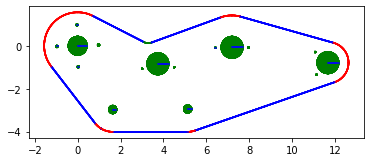

In [4]:
pltnc(nc0)
pltnc(nc1)

In [7]:
nc4 = readnc(dir0 / r'intakev2\front linkage\front_linkage arm_cad_p125_mill_holes.nc')
nc5 = readnc(dir0 / r'intakev2\front linkage\front_linkage arm_cad_p125_mill_perimeter.nc')

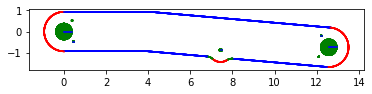

In [8]:
pltnc(nc4)
pltnc(nc5)

In [9]:
limits(nc5)

x: -0.938 13.513
y: -1.684 0.938
z: -0.395 1.000


{'x': (-0.93751, 13.51328), 'y': (-1.68444, 0.9375), 'z': (-0.395, 1.0)}

In [13]:
dir1 = pathlib.Path(r'D:\Users\brian\Documents\GrabCAD\FRC 2429\2022\CAM\router')
nc6 = readnc(dir1 / r'intake\v2\back linkage\linkage arm_cad_back_p125mill_holes.nc')
nc7 = readnc(dir1 / r'intake\v2\back linkage\linkage arm_cad_back_p125mill_perimeter_bdk.nc')

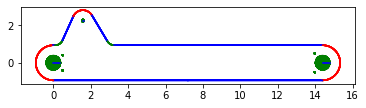

In [14]:
pltnc(nc6)
pltnc(nc7)

In [15]:
ncp0 = readnc(dir1 / r'rotary climber\pawlv4\pawlv4_4x_shapeoko_center_drill_20220318_122911.nc')
ncp1 = readnc(dir1 / r'rotary climber\pawlv4\ratchetPawlV4_p125mill_perimeter.nc')

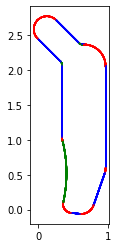

In [17]:
pltnc(ncp1)

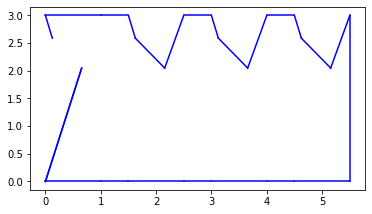

In [18]:
pltnc(ncp0)

In [21]:
nci0 = readnc(dir1 / r'intake\v3 - bigger pistons\intake mount (Al)\v2 intake mount_lexan_p125_holes.nc')
nci1 = readnc(dir1 / r'intake\v3 - bigger pistons\intake mount (Al)\v2 intake_lexan_p125_perimeter.nc')
nci2 = readnc(dir1 / r'intake\v3 - bigger pistons\intake mount (Al)\v2 intake_lexan_p125_all_bdk.nc')

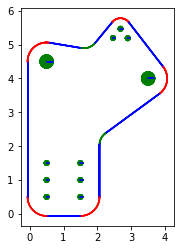

In [22]:
pltnc(nci2)

In [24]:
dir2 = pathlib.Path(r'D:\Users\brian\Documents\GrabCAD\FRC 2429\2022\CAM\mill')
ncr0 = readnc(dir2 / r'climber\ratchetv4p1\first_rotation\ratchetWheelV4p1_cam_0p506_all_vitruvian_HEXHORIZONTAL.nc')

ValueError: invalid literal for int() with base 10: ''

In [32]:
nch0 = readnc(dir1 / r'2PosHood\hoodFinger_holes_0p125.nc')

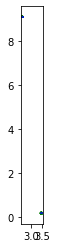

In [33]:
pltnc(nch0)

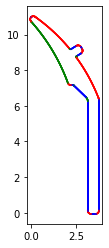

In [34]:
nch1 = readnc(dir1 / r'2PosHood\hoodFinger_perimeter_0p125.nc') 
pltnc(nch1)

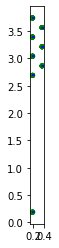

In [35]:
nch1 = readnc(dir1 / r'2PosHood\BackLink_holes_0p125.nc') 
pltnc(nch1)

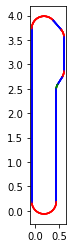

In [36]:
nch1 = readnc(dir1 / r'2PosHood\BackLinkPerimeter_0p125.nc') 
pltnc(nch1)

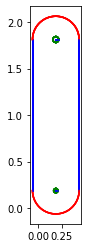

In [38]:
nch1 = readnc(dir1 / r'2PosHood\TopLink_holes_0p125.nc') 
pltnc(nch1)

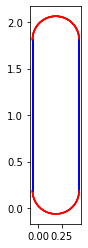

In [39]:
nch1 = readnc(dir1 / r'2PosHood\TopLink_perimeter_0p125.nc') 
pltnc(nch1)

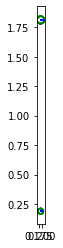

In [40]:
nch1 = readnc(dir1 / r'2PosHood\TopLink_holes_0p125.nc') 
pltnc(nch1)

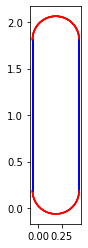

In [41]:
nch1 = readnc(dir1 / r'2PosHood\TopLink_perimeter_0p125.nc') 
pltnc(nch1)

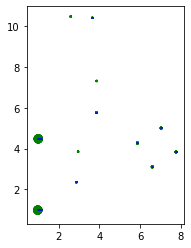

In [42]:
nch1 = readnc(dir1 / r'intake\v3 - bigger pistons\sideplate\v3 intake sideplate_0p125_holeRoughing.nc') 
pltnc(nch1)

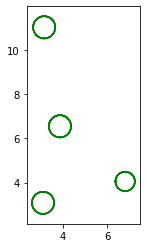

In [43]:
nch1 = readnc(dir1 / r'intake\v3 - bigger pistons\sideplate\v3 intake sideplate_0p125_largeHolePocketing.nc') 
pltnc(nch1)

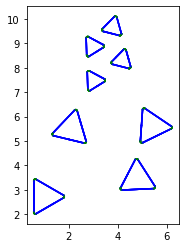

In [44]:
nch1 = readnc(dir1 / r'intake\v3 - bigger pistons\sideplate\v3 intake sideplate_0p125_trianglePockets.nc') 
pltnc(nch1)

In [45]:
nch1 = readnc(dir1 / r'intake\v3 - bigger pistons\sideplate\v3 intake sideplate_0p125_perimeter.nc') 
pltnc(nch1)

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Users\\brian\\Documents\\GrabCAD\\FRC 2429\\2022\\CAM\\router\\intake\\v3 - bigger pistons\\sideplate\\v3 intake sideplate_0p125_perimeter.nc'

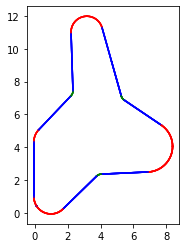

In [46]:
nch1 = readnc(dir1 / r'intake\v3 - bigger pistons\sideplate\v3 intake sideplate_0p125_perimeter.nc') 
pltnc(nch1)